In [13]:
import os
import sys

# allow importing from parent directory
current_folder = globals()['_dh'][0]
data_location = os.path.join(current_folder,'data.csv')
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(data_location), '..')))

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display

from ultralytics import settings
settings.update({"sync": False, "runs_dir": "interim_results"})
from ultralytics import YOLOEdgeUncertainty, YOLO
import cv2
import re
import datetime

FONT_SMALL = 16
FONT_MEDIUM = 18
FONT_LARGE = 20

plt.rcParams['font.size'] = FONT_LARGE
plt.rcParams['axes.labelsize'] = FONT_MEDIUM
plt.rcParams['xtick.labelsize'] = FONT_SMALL
plt.rcParams['ytick.labelsize'] = FONT_SMALL
plt.rcParams['legend.fontsize'] = FONT_SMALL
plt.rcParams['figure.titlesize'] = FONT_MEDIUM
plt.rcParams['axes.titlesize'] = FONT_MEDIUM
plt.rcParams['figure.figsize'] = (16, 8)

In [14]:
order = ["base-pretrained", "base-confidence", "base-uncertainty", "ensemble", "mc-dropout", "edl-meh"]

path_base = '../interim_results/detect'
newest_results = 'data_splits_and_models'
print(f'Results folder: {newest_results}')

datasets = {}
train_dataset_path = [f for f in os.listdir(f'{path_base}/{newest_results}') if f.startswith('train') and os.path.isdir(f'{path_base}/{newest_results}/{f}')][0]
print(f'Train dataset path: {train_dataset_path}')

for dataset_type in ['val']:
    dataset_paths = [f for f in os.listdir(f'{path_base}/{newest_results}') if f.startswith(dataset_type) and os.path.isdir(f'{path_base}/{newest_results}/{f}')]

    for dataset_path in dataset_paths:
        full_dataset_path = f'{path_base}/{newest_results}/{dataset_path}'
        df_results = pd.DataFrame()

        for model_folder in [f for f in os.listdir(full_dataset_path) if os.path.isdir(f'{full_dataset_path}/{f}')]:
            df_results_model = pd.read_csv(f'{full_dataset_path}/{model_folder}/results_extended.csv')

            if df_results.empty:
                df_results = df_results_model
            else:
                df_results = pd.concat([df_results, df_results_model])

        df_results.set_index('name', inplace=True)
        df_results = df_results.loc[order, :]

        print(f'Processing dataset: {dataset_path}')
        display(df_results)  

        # complement mUE metric, so higher is better now
        df_results['1 - metrics/mUE50'] = 1 - df_results['metrics/mUE50']
        df_results.drop(columns=['metrics/mUE50'], inplace=True)
        df_results['1 - metrics/mUE50-95'] = 1 - df_results['metrics/mUE50-95']
        df_results.drop(columns=['metrics/mUE50-95'], inplace=True)
        df_results['1 - metrics/mUE50_correct'] = 1 - df_results['metrics/mUE50_correct']
        df_results.drop(columns=['metrics/mUE50_correct'], inplace=True)
        df_results['1 - metrics/mUE50-95_correct'] = 1 - df_results['metrics/mUE50-95_correct']
        df_results.drop(columns=['metrics/mUE50-95_correct'], inplace=True)
        df_results['1 - metrics/mUE50_incorrect'] = 1 - df_results['metrics/mUE50_incorrect']
        df_results.drop(columns=['metrics/mUE50_incorrect'], inplace=True)
        df_results['1 - metrics/mUE50-95_incorrect'] = 1 - df_results['metrics/mUE50-95_incorrect']
        df_results.drop(columns=['metrics/mUE50-95_incorrect'], inplace=True)

        speed_cols = [col for col in df_results.columns if 'speed' in col]
        df_results['speed_total'] = df_results[speed_cols].sum(axis=1)
        datasets[dataset_path] = df_results

Results folder: data_splits_and_models
Train dataset path: train-cityscapes-train-kitti-val-from-coco80
Processing dataset: val-raincityscapes-from-coco80


,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),metrics/mUE50,metrics/mUE50_thres,metrics/mUE50-95,metrics/mUE50-95_thres,metrics/mUE50_correct,metrics/mUE50_incorrect,metrics/mUE50-95_correct,metrics/mUE50-95_incorrect,fitness,speed_preprocess,speed_inference,speed_loss,speed_postprocess
name,,,,,,,,,,,,,,,,,
base-pretrained,0.367428,0.241466,0.259274,0.165380,0.202485,0.96,0.140197,0.870,0.094864,0.107621,0.079742,0.060456,0.514172,0.088435,0.569784,0.000366,0.739597
base-confidence,0.407280,0.245712,0.285786,0.178460,0.183975,0.91,0.124997,0.830,0.124093,0.059882,0.078682,0.046315,0.529149,0.093123,0.512753,0.000353,0.785820
base-uncertainty,0.407280,0.245712,0.285786,0.178460,0.449876,6.31,0.377306,6.310,0.449666,0.000210,0.376891,0.000415,0.402315,0.088510,0.555497,0.000348,0.696035
ensemble,0.855450,0.119853,0.207836,0.134367,0.276221,0.86,0.214966,0.540,0.154073,0.122148,0.126087,0.088879,0.460311,0.086848,1.202361,0.000436,0.523865
mc-dropout,0.407131,0.239815,0.281086,0.175614,0.235911,0.31,0.158692,0.220,0.167509,0.068402,0.108062,0.050630,0.509874,0.093608,0.641480,0.000352,0.777080
edl-meh,0.440947,0.231814,0.279431,0.175567,0.233876,0.51,0.170510,0.355,0.144347,0.089530,0.102973,0.067537,0.504553,0.094214,2.180282,0.000366,0.713749


Processing dataset: val-foggy-cityscapes-from-coco80


,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),metrics/mUE50,metrics/mUE50_thres,metrics/mUE50-95,metrics/mUE50-95_thres,metrics/mUE50_correct,metrics/mUE50_incorrect,metrics/mUE50-95_correct,metrics/mUE50-95_incorrect,fitness,speed_preprocess,speed_inference,speed_loss,speed_postprocess
name,,,,,,,,,,,,,,,,,
base-pretrained,0.401346,0.235761,0.238946,0.152673,0.194177,0.96,0.133343,0.860,0.090494,0.103684,0.081524,0.051819,0.510937,0.080038,0.562760,0.000380,0.690256
base-confidence,0.456488,0.276978,0.276859,0.174042,0.177060,0.91,0.120654,0.845,0.117534,0.059527,0.074725,0.045929,0.529015,0.053475,0.440720,0.000383,0.742957
base-uncertainty,0.456488,0.276978,0.276859,0.174042,0.439145,6.31,0.364683,6.310,0.438905,0.000240,0.364197,0.000486,0.406097,0.082384,0.669108,0.000372,0.744655
ensemble,0.702599,0.125404,0.185828,0.122474,0.266109,0.56,0.210296,0.385,0.165201,0.100907,0.127120,0.083176,0.456466,0.067514,1.197310,0.000378,0.608220
mc-dropout,0.450317,0.264966,0.267541,0.167825,0.216036,0.31,0.152028,0.185,0.141167,0.074869,0.103626,0.048402,0.509684,0.083511,0.638216,0.000346,0.704417
edl-meh,0.441125,0.260921,0.268824,0.170182,0.211785,0.46,0.158552,0.300,0.126834,0.084951,0.096132,0.062421,0.508086,0.082374,2.160636,0.000361,0.673915


Processing dataset: val-kitti-from-coco80


,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),metrics/mUE50,metrics/mUE50_thres,metrics/mUE50-95,metrics/mUE50-95_thres,metrics/mUE50_correct,metrics/mUE50_incorrect,metrics/mUE50-95_correct,metrics/mUE50-95_incorrect,fitness,speed_preprocess,speed_inference,speed_loss,speed_postprocess
name,,,,,,,,,,,,,,,,,
base-pretrained,0.471603,0.383547,0.363639,0.178976,0.128389,0.86,0.102612,0.805,0.079329,0.049060,0.061093,0.041519,0.546126,0.031082,0.343957,0.000354,0.593271
base-confidence,0.548084,0.369107,0.398554,0.199851,0.118633,0.81,0.096407,0.740,0.078087,0.040546,0.063792,0.032615,0.560546,0.034405,0.335590,0.000382,0.582517
base-uncertainty,0.548084,0.369107,0.398554,0.199851,0.397324,6.31,0.330281,6.310,0.397106,0.000218,0.329469,0.000812,0.441368,0.027731,0.339944,0.000399,0.569701
ensemble,0.844734,0.251440,0.316461,0.156631,0.196761,0.26,0.170111,0.175,0.107911,0.088850,0.098496,0.071615,0.499919,0.033460,0.704672,0.000342,0.522612
mc-dropout,0.512003,0.371717,0.395785,0.199000,0.159898,0.26,0.134415,0.185,0.099857,0.060041,0.089685,0.044729,0.540858,0.026994,0.404833,0.000368,0.552357
edl-meh,0.486449,0.363381,0.382449,0.191141,0.178154,0.36,0.157039,0.260,0.100055,0.078099,0.096612,0.060427,0.525561,0.026933,1.370788,0.000423,0.537972


Processing dataset: val-cityscapes-from-coco80


,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),metrics/mUE50,metrics/mUE50_thres,metrics/mUE50-95,metrics/mUE50-95_thres,metrics/mUE50_correct,metrics/mUE50_incorrect,metrics/mUE50-95_correct,metrics/mUE50-95_incorrect,fitness,speed_preprocess,speed_inference,speed_loss,speed_postprocess
name,,,,,,,,,,,,,,,,,
base-pretrained,0.528370,0.276371,0.292189,0.176769,0.188730,0.91,0.133757,0.830,0.116964,0.071766,0.081660,0.052097,0.524528,0.079649,0.915288,0.000342,1.505299
base-confidence,0.516175,0.328523,0.342015,0.204287,0.176954,0.91,0.122722,0.795,0.090459,0.086495,0.076462,0.046260,0.544957,0.160768,0.649080,0.000391,1.091176
base-uncertainty,0.516175,0.328523,0.342015,0.204287,0.438666,6.31,0.360982,6.310,0.438423,0.000243,0.360477,0.000505,0.424655,0.167415,0.756514,0.000414,1.069354
ensemble,0.691595,0.151872,0.210226,0.132214,0.274246,0.56,0.209175,0.305,0.160502,0.113743,0.130533,0.078642,0.462166,0.154048,2.750704,0.000416,0.602440
mc-dropout,0.474203,0.339004,0.334041,0.200076,0.214914,0.31,0.152190,0.195,0.139196,0.075718,0.100023,0.052166,0.527505,0.207220,0.732846,0.000362,0.853248
edl-meh,0.438810,0.320704,0.330339,0.198020,0.219722,0.46,0.162787,0.295,0.130459,0.089263,0.099223,0.063564,0.521386,0.125574,2.278138,0.000380,1.091358


In [15]:
chosen_val_dataset = 'val-kitti-from-coco80'
path = f'{path_base}/{newest_results}/{chosen_val_dataset}'
df_selected = datasets[chosen_val_dataset]

names_title_case = df_selected.index.str.replace('-', ' ').str.title().str.replace('Edl', 'EDL').str.replace('Meh', 'MEH').str.replace('Mc', 'MC').values
print(names_title_case)

rename_dict_index = {k: v for k, v in zip(df_selected.index.values, names_title_case)}

['Base Pretrained' 'Base Confidence' 'Base Uncertainty' 'Ensemble' 'MC Dropout' 'EDL MEH']


In [16]:
for df in datasets.values():
    df.rename(index=rename_dict_index, inplace=True)

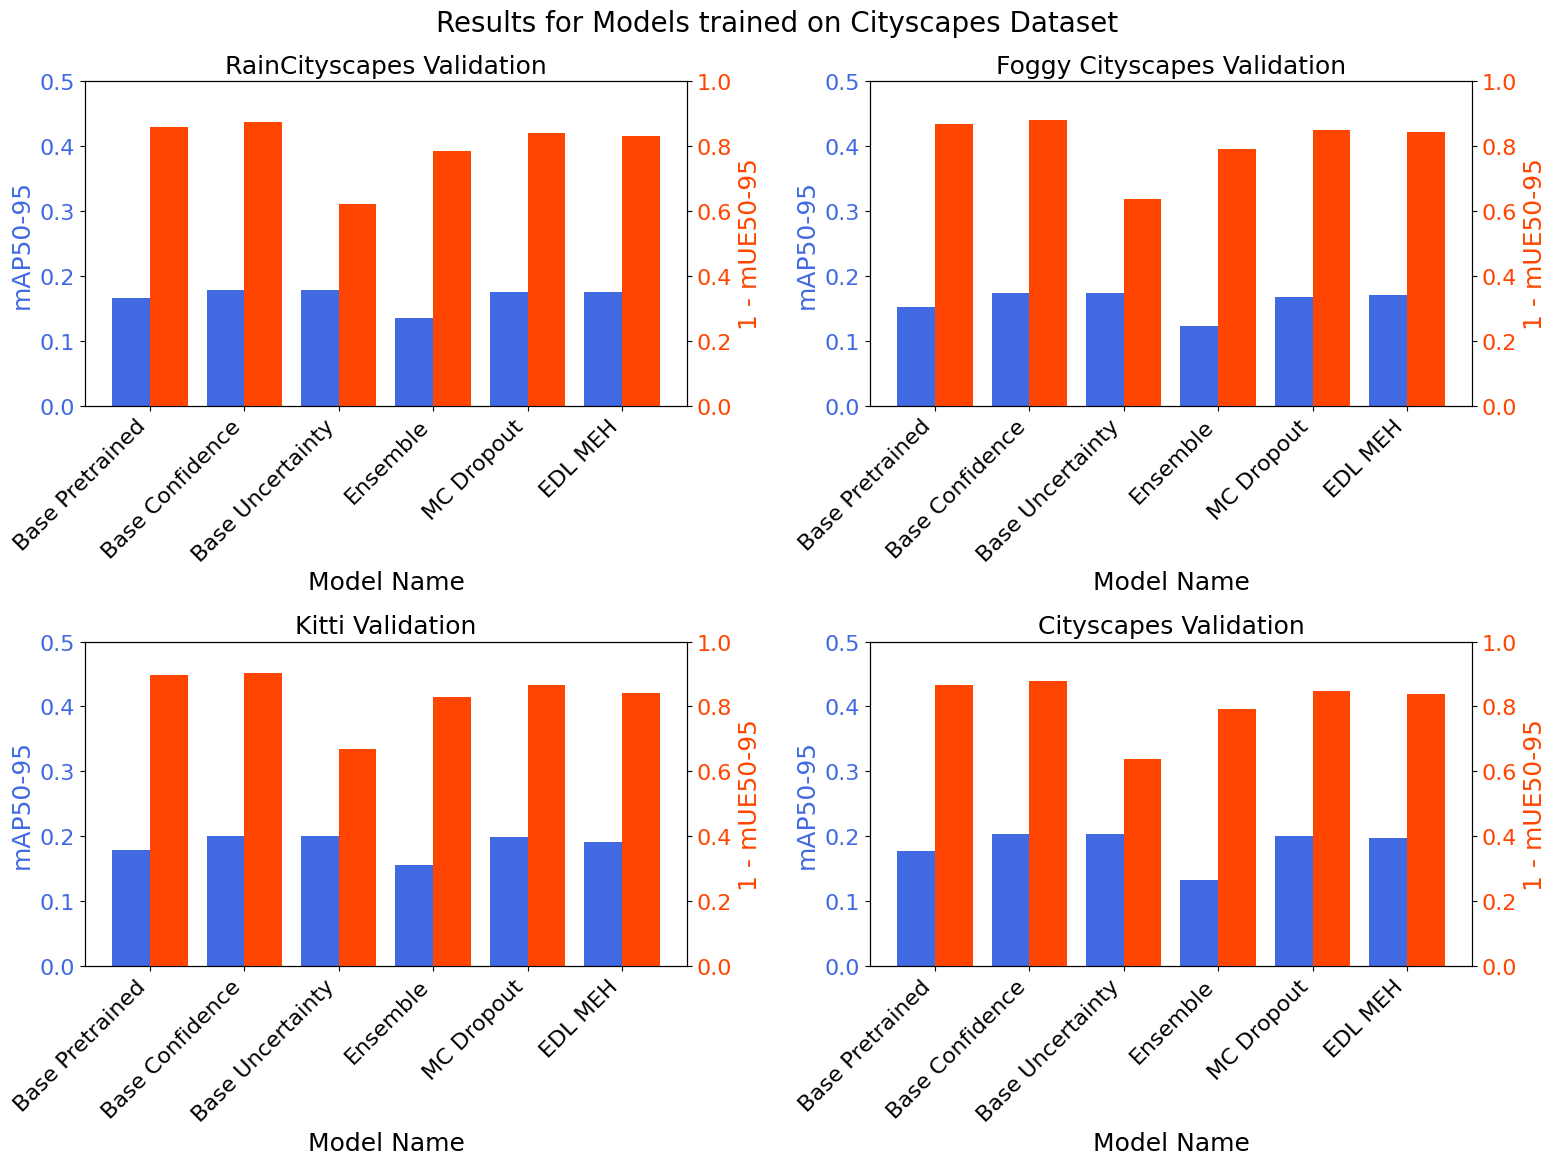

In [17]:
metric1 = 'metrics/mAP50-95(B)'
metric2 = '1 - metrics/mUE50-95'

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()

for idx, (key, df) in enumerate(datasets.items()):
    if idx >= 4:
        break
    ax1 = axs[idx]

    color_1 = 'royalblue'
    ax1.set_xlabel('Model Name')
    ax1.set_ylabel('mAP50-95', color=color_1)
    ax1.bar(df.index, df[metric1], color=color_1, width=0.4, label=metric1)
    ax1.tick_params(axis='y', labelcolor=color_1)

    ax2 = ax1.twinx()
    color_2 = 'orangered'
    ax2.set_ylabel('1 - mUE50-95', color=color_2)
    ax2.bar([i + 0.4 for i in range(len(df.index))], df[metric2], color=color_2, width=0.4, label=metric2)
    ax2.tick_params(axis='y', labelcolor=color_2)

    ax1.set_xticks([i + 0.2 for i in range(len(df.index))])
    ax1.set_xticklabels(df.index, rotation=45, ha='right')
    ax1.set_title(f"{key.replace('val-', '').replace('-from-coco80', '').replace('-', ' ').title().replace('Raincityscapes', 'RainCityscapes')} Validation")

    ax1.set_ylim(0, 0.5)
    ax2.set_ylim(0, 1.0)
fig.tight_layout()

fig.suptitle(f"Results for Models trained on {train_dataset_path.split('train')[1].replace('-', '').title()} Dataset", fontsize=FONT_LARGE)
plt.subplots_adjust(top=0.92)

plt.show()

,Precision,Recall,mAP50-95,FPS,1 - mUE50-95
name,,,,,
Base Pretrained,1.000000,1.000000,1.000000,1.000000,1.000000
Base Confidence,1.162172,0.962352,1.116639,1.016549,1.006915
Base Uncertainty,1.162172,0.962352,1.116639,1.032937,0.746298
Ensemble,1.791199,0.655565,0.875151,0.768119,0.924783
MC Dropout,1.085667,0.969157,1.111884,0.983862,0.964561
EDL MEH,1.031480,0.947423,1.067971,0.500313,0.939350


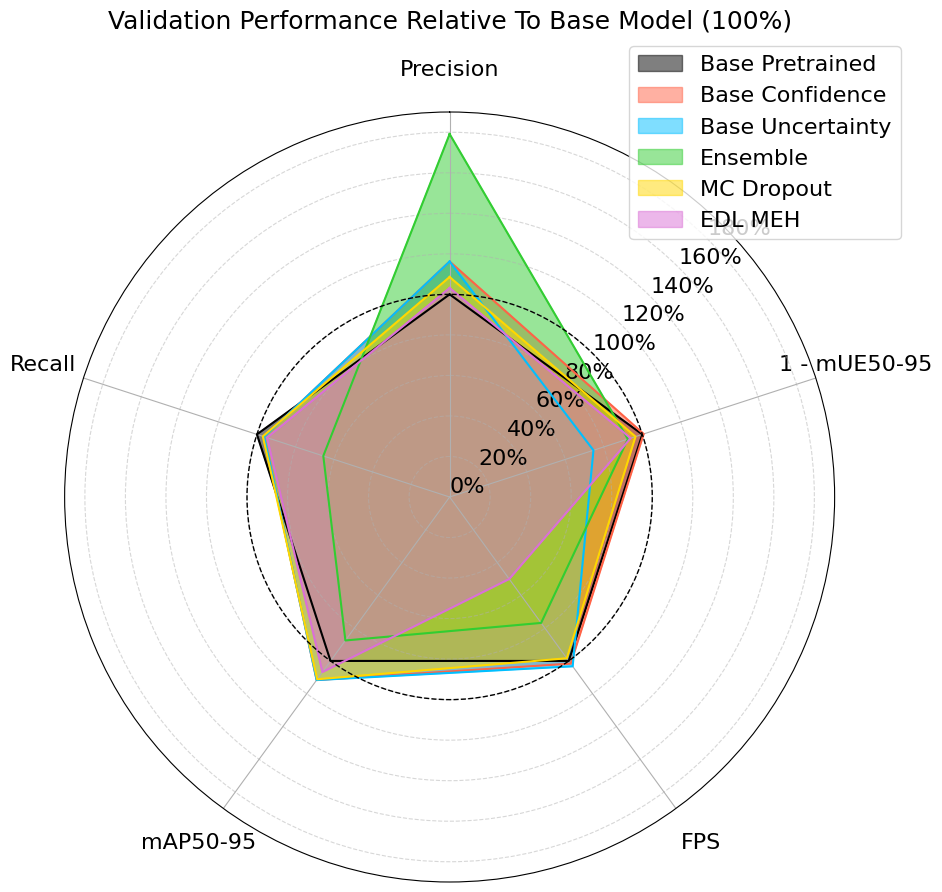

In [18]:
rename_dict_cols = {
    'metrics/precision(B)' : 'Precision',
    'metrics/recall(B)' : 'Recall',
    'metrics/mAP50-95(B)' : 'mAP50-95',
    'speed_total' : 'FPS',
    '1 - metrics/mUE50-95' : '1 - mUE50-95',
}

color_list = ['k', 'tomato', 'deepskyblue', 'limegreen', 'gold', 'orchid', 'lightcoral', 'lightseagreen']
colors = {idx: color for idx, color in zip(names_title_case, color_list[:len(names_title_case)])}

df = df_selected[rename_dict_cols.keys()]
# take inverse of inference time as fps
df.loc[:, 'speed_total'] = 1 / df['speed_total']
# take base index, and normalize all values to it
df = df / df.iloc[0]

df.rename(index=rename_dict_index, inplace=True)
df.rename(columns=rename_dict_cols, inplace=True)


display(df)

categories = list(df.columns)
num_vars = len(categories)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Repeat the first angle to close the plot

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for idx in df.index:
    values = df.loc[idx].tolist()
    values += values[:1]  # Repeat the first value to close the plot
    ax.fill(angles, values, alpha=0.50, color=colors[idx], label=idx)
    ax.plot(angles, values, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

ylim = round(max(df.max()), 1) + 0.1
ax.set_ylim(0, ylim)

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

ax.tick_params(axis='x', pad=20)
ax.set_yticks(np.arange(0, ylim, 0.2))
ax.set_yticklabels(ax.get_yticks(), rotation=45)

ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
ax.set_theta_offset(np.pi / 2)

ax.yaxis.grid(True, linestyle='--', alpha=0.5)
ax.axhline(1, color='black', linewidth=1, linestyle='--')
ax.set_rlabel_position(-45)
ax.set_title(f"{'Training' if 'train' in path else 'Validation'} Performance relative to base model (100%)".title(), pad=60)
ax.title.set_position([.5, 1.4])

plt.savefig(f'{path}/radar_chart.png', bbox_inches='tight', dpi=600)
plt.savefig(f'{path}/radar_chart.pdf', bbox_inches='tight')
plt.show()